In [2]:
import pandas as pd
import numpy as np

import re
import string

import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
review_data= pd.read_csv("Reviews.csv")
print(review_data.head(2))
print(len(review_data))
print('Unique Products')
print(len(review_data.groupby('ProductId')))
print('Unique Users')
print(len(review_data.groupby('UserId')))

   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
568454
Unique Products
74258
Unique Users
256059


In [4]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [6]:
import nltk
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to C:\Users\RITIK
[nltk_data]     SETH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
review_data.dropna(axis = 0, how ='any',inplace=True) 
review_data['Text'] = review_data['Text'].apply(clean_text)
review_data['Num_words_text'] = review_data['Text'].apply(lambda x:len(str(x).split())) 

print('-------Dataset --------')
print(review_data['Score'].value_counts())
print(len(review_data))
print('-------------------------')
max_review_data_sentence_length  = review_data['Num_words_text'].max()


mask = (review_data['Num_words_text'] < 100) & (review_data['Num_words_text'] >=20)
df_short_reviews = review_data[mask]
df_sampled = df_short_reviews.groupby('Score').apply(lambda x: x.sample(n=20000)).reset_index(drop = True)

print('No of Short reviews')
print(len(df_short_reviews))

-------Dataset --------
5    363111
4     80655
1     52264
3     42638
2     29743
Name: Score, dtype: int64
568411
-------------------------
No of Short reviews
373281


In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# function to remove stopwords
def remove_stopwords(text):
    textArr = text.split(' ')
    rem_text = " ".join([i for i in textArr if i not in stop_words])
    return rem_text

# remove stopwords from the text
df_sampled['Text']=df_sampled['Text'].apply(remove_stopwords)

In [12]:
!python -m spacy download en_core_web_md

2022-09-05 13:00:53.350277: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-09-05 13:00:53.350321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-05 13:00:56.210193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-09-05 13:00:56.210745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublas64_11.dll'; dlerror: cublas64_11.dll not found
2022-09-05 13:00:56.211273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cublasLt64_11.dll'; dlerror: cublasLt64_11.dll not found
2022-09-05 13:00:56.211852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cu


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


Skipping registering GPU devices...


In [13]:
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']): 
       output = []
       for sent in texts:
             doc = nlp(sent) 
             output.append([token.lemma_ for token in doc if token.pos_ in allowed_postags ])
       return output

In [14]:
text_list=df_sampled['Text'].tolist()
print(text_list[1])
tokenized_reviews = lemmatization(text_list)
print(tokenized_reviews[1])

read good reviews teeccino java herbal coffee went local whole foods purchase teeccino original light roast herbal coffee thought anyway wasnt expecting taste like coffee looking beverage without caffeine tasted good cant find words describe awful flavor made daughter help describe flavor said smells like plastic wasted money buying product
['good', 'review', 'coffee', 'local', 'whole', 'food', 'teeccino', 'original', 'light', 'roast', 'herbal', 'coffee', 'taste', 'coffee', 'beverage', 'caffeine', 'good', 'word', 'awful', 'flavor', 'daughter', 'help', 'flavor', 'plastic', 'money', 'product']


In [15]:
dictionary = corpora.Dictionary(tokenized_reviews)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized_reviews]

In [16]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=10, random_state=100,
                chunksize=500, passes=20,iterations=20)

In [17]:
lda_model.print_topics()

[(0,
  '0.032*"good" + 0.025*"sauce" + 0.021*"flavor" + 0.020*"bar" + 0.020*"great" + 0.015*"time" + 0.015*"perfect" + 0.014*"cheese" + 0.014*"pasta" + 0.014*"gift"'),
 (1,
  '0.097*"food" + 0.023*"ingredient" + 0.020*"organic" + 0.020*"healthy" + 0.018*"rice" + 0.017*"product" + 0.017*"meal" + 0.017*"free" + 0.015*"good" + 0.014*"chicken"'),
 (2,
  '0.123*"coffee" + 0.033*"flavor" + 0.027*"good" + 0.023*"strong" + 0.018*"taste" + 0.016*"bean" + 0.014*"smooth" + 0.013*"vanilla" + 0.012*"great" + 0.011*"blend"'),
 (3,
  '0.044*"snack" + 0.040*"chip" + 0.034*"cookie" + 0.029*"great" + 0.029*"flavor" + 0.028*"good" + 0.025*"salt" + 0.022*"butter" + 0.019*"peanut" + 0.019*"taste"'),
 (4,
  '0.050*"candy" + 0.035*"soft" + 0.023*"piece" + 0.021*"seed" + 0.017*"coat" + 0.016*"hard" + 0.016*"small" + 0.015*"color" + 0.015*"nice" + 0.014*"stick"'),
 (5,
  '0.042*"time" + 0.031*"minute" + 0.023*"cracker" + 0.022*"pound" + 0.017*"long" + 0.016*"skin" + 0.016*"bone" + 0.015*"last" + 0.014*"fish" +

In [18]:
# Visualize the topics
#https://github.com/bmabey/pyLDAvis
#https://speakerdeck.com/bmabey/visualizing-topic-models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\RITIK SETH\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.099220 -0.116601       1        1  20.105740
8      0.187300  0.083488       2        1  16.386706
2      0.137994  0.087223       3        1  12.691047
0      0.119178  0.014905       4        1  10.204242
3      0.163399  0.123044       5        1   9.552037
6      0.008501 -0.165933       6        1   9.037253
1      0.083564 -0.141740       7        1   8.420345
5     -0.271265 -0.234384       8        1   4.674572
7     -0.301153  0.120311       9        1   4.510656
4     -0.226739  0.229686      10        1   4.417401, topic_info=       Term          Freq         Total Category  logprob  loglift
18   coffee  30809.000000  30809.000000  Default  30.0000  30.0000
21     food  23023.000000  23023.000000  Default  29.0000  29.0000
140   store  14645.000000  14645.000000  Default  28.0000  28.0000
20   flavor  32213.000000  32213.000000  Default  27.0000  27.0000
282   treat   9477.000000   9477.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
604   thick    728.771822   1480.122157  Topic10  -4.7875   2.4111
650   white    748.569852   2137.680663  Topic10  -4.7607   2.0703
250     one    805.469582   3075.941397  Topic10  -4.6874   1.7797
887    size    868.256058   5508.582126  Topic10  -4.6124   1.2720
89    fresh    623.924488   6198.013059  Topic10  -4.9428   0.8237

[512 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5774      6  0.998026  addictive
3694      7  0.999278      adult
443       9  0.998349  afternoon
1216      6  0.998973    allergy
943       1  0.999782     almond
...     ...       ...        ...
254       6  0.215226       year
254       7  0.113190       year
254       8  0.059630       year
3281      8  0.999367      young
223       2  0.999528      yummy

[718 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 3, 1, 4, 7, 2, 6, 8, 5])

In [19]:
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_reviews, dictionary=dictionary , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.848282746588506

Coherence Score:  0.4179949147952625


In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=tokenized_reviews, start=2, limit=50, step=1)

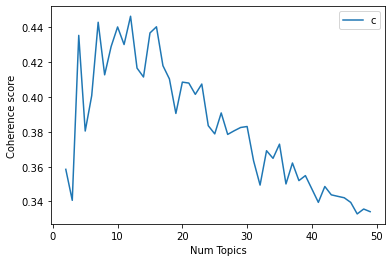

In [22]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3585
Num Topics = 3  has Coherence Value of 0.3407
Num Topics = 4  has Coherence Value of 0.4354
Num Topics = 5  has Coherence Value of 0.3805
Num Topics = 6  has Coherence Value of 0.4008
Num Topics = 7  has Coherence Value of 0.443
Num Topics = 8  has Coherence Value of 0.4128
Num Topics = 9  has Coherence Value of 0.429
Num Topics = 10  has Coherence Value of 0.4403
Num Topics = 11  has Coherence Value of 0.4302
Num Topics = 12  has Coherence Value of 0.4464
Num Topics = 13  has Coherence Value of 0.4166
Num Topics = 14  has Coherence Value of 0.4115
Num Topics = 15  has Coherence Value of 0.4368
Num Topics = 16  has Coherence Value of 0.4404
Num Topics = 17  has Coherence Value of 0.418
Num Topics = 18  has Coherence Value of 0.4104
Num Topics = 19  has Coherence Value of 0.3906
Num Topics = 20  has Coherence Value of 0.4086
Num Topics = 21  has Coherence Value of 0.408
Num Topics = 22  has Coherence Value of 0.4016
Num Topics = 23  has Cohe

In [24]:
# Select the model and print the topics
optimal_model = model_list[7]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.022*"time" + 0.020*"little" + 0.020*"sauce" + 0.019*"good" + 0.016*"flavor" + 0.014*"small" + 0.012*"cheese" + 0.012*"great" + 0.012*"pasta" + 0.012*"popcorn"'),
 (1,
  '0.036*"protein" + 0.035*"cereal" + 0.023*"energy" + 0.020*"product" + 0.018*"great" + 0.017*"fiber" + 0.016*"milk" + 0.015*"good" + 0.012*"high" + 0.012*"carb"'),
 (2,
  '0.044*"store" + 0.042*"price" + 0.036*"product" + 0.025*"great" + 0.023*"good" + 0.022*"order" + 0.020*"local" + 0.019*"time" + 0.015*"grocery" + 0.014*"amazon"'),
 (3,
  '0.073*"food" + 0.033*"treat" + 0.023*"product" + 0.023*"dog" + 0.016*"cat" + 0.014*"year" + 0.014*"good" + 0.013*"great" + 0.011*"time" + 0.010*"month"'),
 (4,
  '0.052*"chip" + 0.029*"flavor" + 0.025*"salt" + 0.023*"good" + 0.018*"great" + 0.016*"rice" + 0.016*"potato" + 0.012*"hair" + 0.012*"sweet" + 0.011*"taste"'),
 (5,
  '0.036*"good" + 0.031*"snack" + 0.026*"cookie" + 0.025*"great" + 0.016*"bar" + 0.016*"taste" + 0.016*"healthy" + 0.015*"free" + 0.014*"product" + 0.0

In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, doc_term_matrix, dictionary)
vis

C:\Users\RITIK SETH\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.115471  0.016828       1        1  16.475015
2      0.166455  0.092838       2        1  15.359637
3      0.181744  0.079761       3        1  13.888970
8     -0.113359 -0.058867       4        1  13.680052
5     -0.002325  0.063196       5        1  10.602399
0      0.049577  0.107297       6        1  10.162908
4     -0.116008  0.062771       7        1   7.691198
6     -0.200483 -0.062668       8        1   6.755796
1      0.149870 -0.301155       9        1   5.384026, topic_info=          Term          Freq         Total Category  logprob  loglift
18      coffee  30529.000000  30529.000000  Default  30.0000  30.0000
21        food  23036.000000  23036.000000  Default  29.0000  29.0000
140      store  14207.000000  14207.000000  Default  28.0000  28.0000
51        chip   7931.000000   7931.000000  Default  27.0000  27.0000
285  chocolate  11109.000000  11109.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
365    healthy    768.429971   8185.514799   Topic9  -4.9324   0.5560
630       work    584.063190   4232.460236   Topic9  -5.2067   0.9412
152     people    577.036848   3965.267115   Topic9  -5.2188   0.9943
296      stuff    545.309290   6216.485997   Topic9  -5.2754   0.4881
578     powder    521.299673   2479.401490   Topic9  -5.3204   1.3623

[626 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3247      9  0.995121     active
1815      2  0.997885   addicted
1815      5  0.002332   addicted
4367      4  0.998520  addicting
4595      5  0.994415  addiction
...     ...       ...        ...
223       1  0.101824      yummy
223       4  0.169066      yummy
223       5  0.587887      yummy
223       7  0.119595      yummy
223       9  0.022094      yummy

[1662 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 4, 9, 6, 1, 5, 7, 2])